<a href="https://colab.research.google.com/github/SageSquash/Major-Project/blob/main/AGCIE%2BBPDHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import cv2
import time
import numpy as np
import scipy.ndimage
from skimage.exposure import histogram
from google.colab.patches import cv2_imshow

class Histogram:

	def sub_histogram_equalization(self, histogram, range_min = 0, range_max = 255):
		cdf = histogram.cumsum()
		cdf_mask = np.ma.masked_equal(cdf, 0)
	
		# Scale cdf to [range_min, range_max]
		scale_cdf_mask = ((cdf_mask - cdf_mask.min()) * (range_max - range_min) / (cdf_mask.max() - cdf_mask.min())) + range_min
		LUT = np.ma.filled(scale_cdf_mask, 0).astype('uint8')

		return LUT

	def histogram_equalization(self, image_1d, range_min = 0, range_max = 255):
		histogram, _ = np.histogram(image_1d, range_max - range_min + 1, [range_min, range_max])

		return self.sub_histogram_equalization(histogram, range_min, range_max)

	def histogram_equalization_threshold(self, image_1d, threshold, start = 0, end = 255):
		lower_filter = image_1d <= threshold
		lower_1d = image_1d[lower_filter]

		upper_filter = image_1d > threshold
		upper_1d = image_1d[upper_filter]

		lower_input_lut = np.array([])
		if start > 0:
			for i in range(0, start):
				lower_input_lut = np.append(lower_input_lut, i)

		upper_input_lut = np.array([])
		if end < 255:
			for i in range(end + 1, 256):
				upper_input_lut = np.append(upper_input_lut, i)

		lower_LUT = self.histogram_equalization(lower_1d, start, threshold)
		upper_LUT = self.histogram_equalization(upper_1d, threshold + 1, end)

		lower_LUT = np.concatenate((lower_input_lut, lower_LUT))
		upper_LUT = np.concatenate((upper_LUT, upper_input_lut))

		LUT = np.concatenate((lower_LUT, upper_LUT))

		return LUT

	def histogram_equalization_recursively(self, image_1d, separate_func, recursive, start = 0, end = 255):
		if recursive > 0:
			separate = separate_func(image_1d)
			separate = math.floor(separate)

			lower_filter = image_1d <= separate
			lower_1d = image_1d[lower_filter]
			
			lower_equalization = self.histogram_equalization_recursively(lower_1d, separate_func, recursive - 1, start, separate)

			upper_filter = image_1d > separate
			upper_1d = image_1d[upper_filter]

			upper_equalization = self.histogram_equalization_recursively(upper_1d, separate_func, recursive - 1, separate + 1, end)

			return np.concatenate((lower_equalization, upper_equalization))
		else:
			return self.histogram_equalization(image_1d, start, end)


In [2]:
import math
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

class Utils:
	def __init__(self, image, color_space = 'HSV'):
		self.image = image
		self.color_space = color_space

	def image_gray(self):
		if (self.color_space == 'HSV'):
			image_hsv = cv.cvtColor(self.image, cv.COLOR_BGR2HSV)
			self.image_color = image_hsv

			return image_hsv[:, :, 2]
		elif (self.color_space == 'Gray'):
			image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
			self.image_color = image_gray

			return image_gray
		else:
			self.image_color = self.image
			return self.image

	def LUT_image(self, LUT):
		if (self.color_space == 'HSV'):
			for i in range(0, len(self.image_color)):
				for j in range(0, len(self.image_color[0])):
					self.image_color[i][j][2] = LUT[self.image_color[i][j][2]]

			return cv.cvtColor(self.image_color, cv.COLOR_HSV2BGR)
		elif (self.color_space == 'Gray'):
			return LUT[self.image_color]
		else:
			return self.image_color

	def is_gray_image(self):
		blue, green, red = cv2.split(self.image)

		difference_red_green = np.count_nonzero(abs(red - green))
		difference_green_blue = np.count_nonzero(abs(green - blue))
		difference_blue_red = np.count_nonzero(abs(blue - red))

		difference_sum = float(difference_red_green + difference_green_blue + difference_blue_red)

		ratio = difference_sum / self.image.size

		if ratio>0.005:
				return False
		else:
				return True

	def minimum_mean_brightness_error(self, image_1d):
		length = len(image_1d)

		unique_1d = np.unique(image_1d)
		max_1d = len(unique_1d)

		histogram, _ = np.histogram(image_1d, 256, [0, 255])

		mean = 0
		for i in range(0, len(unique_1d)):
			mean += i * histogram[unique_1d[i]]

		smbe = max_1d * (length - histogram[unique_1d[0]]) - 2 * mean
		asmbe = abs(smbe)
		position = 0
		for i in range(1, len(unique_1d)):
			smbe += (length - max_1d * histogram[unique_1d[i]])
			if asmbe > abs(smbe):
				asmbe = abs(smbe)
				position = i

		return unique_1d[position]

In [ ]:
class IE:
    def __init__(self, image, color_space = 'HSV'):
        self.image = image
        self.color_space = color_space

    def AGCIE(self, contrast_threshold = 3):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten() / 255

        mean = np.mean(image_1d)
        std = np.std(image_1d)
        LUT = np.arange(0, 256) / 255

        if std <= 1 / (4 * contrast_threshold):
            gamma = -math.log(std, 2)
        else:
            gamma = math.exp((1 - (mean + std))/2)

        if mean >= 0.5:
            LUT = 255 * (LUT ** gamma)
        else:
            for i in range(0, 256):
                LUT[i] = 255 * (LUT[i] ** gamma / (LUT[i] ** gamma + (1 - LUT[i] ** gamma) * mean ** gamma)) 

        LUT = LUT.astype('uint8')

        return utils.LUT_image(LUT)

In [3]:
import math
import numpy as np
from math import log2
from skimage.metrics import structural_similarity as ssim

class Quantitation:
  # Absolute Mean Brightness Error
  def AMBE(self, image_input, image_output):
    return abs(np.mean(image_input) - np.mean(image_output))

  # Mean Square Error
  def MSE(self, image_input, image_output):
    # err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    # err /= float(image_input.shape[0] * image_input.shape[1])
    # return err
    err = 10 * math.log10((255 * 255)/cv2.PSNR(image_input, image_output))
    return err

  # Peak Signal to Noise Ratio
  def PSNR(self, image_input, image_output):
    # return 10 * math.log10((255 * 255) / MSE(image_input, image_output))
    return cv2.PSNR(image_input, image_output)
  
  def SNR(self, image_input, image_output):
    ibg = 0
    signal = ((image_input + image_output) / 2 - ibg).sum()
    f = (0.5 ** 0.5) * ((2 / np.pi) ** -0.5)
    noise = np.abs(image_input - image_output).sum() * f
    snr = signal / noise
    return snr
  def SSIM(self, image_input, image_output):
    # return ssim(image_input, image_output, win_size=1, use_sample_covariance=False)
    return ssim(image_input, image_output,multichannel=True)

In [ ]:
import PIL
import cv2
from PIL import Image
import numpy as np
from IPython.display import display
from numpy import cumsum
import sys
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow
img3 = cv2.imread("/content/4.2.05.jpg",cv2.IMREAD_COLOR)

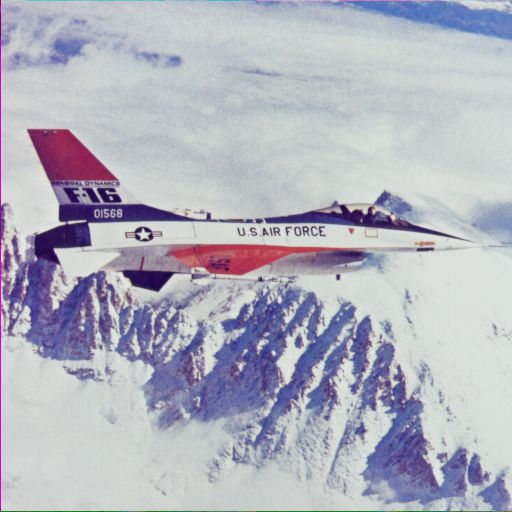

In [ ]:
cv2_imshow(img3)

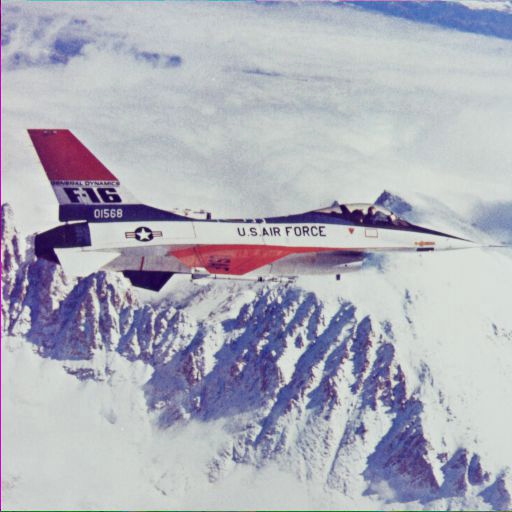

In [ ]:
check = IE(img3)
img_output = check.AGCIE()
cv2_imshow(img_output)

In [ ]:
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))

32.46787515410601
36.83772873025162
3.5505892435709825
22.608738980827656


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


0.9983519887995703


In [ ]:
import cv2

def apply_clahe(input_image):
    # Convert the input image to grayscale
    image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Apply CLAHE to the image
    equalized = clahe.apply(image)

    return equalized

In [ ]:
import cv2
import numpy as np

def apply_mhe(input_image):
    # Convert the input image to grayscale
    image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Calculate the histogram of the image
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])

    # Calculate the cumulative distribution function (CDF) of the histogram
    cdf = hist.cumsum()

    # Calculate the modified cumulative distribution function (MCDF)
    mcdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())

    # Map the pixel values to their corresponding MCDF values
    equalized_image = np.interp(image.flatten(), bins[:-1], mcdf).reshape(image.shape)

    return equalized_image.astype(np.uint8)

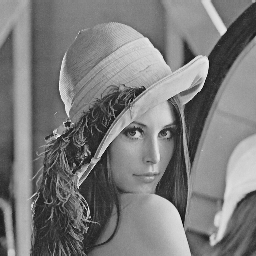

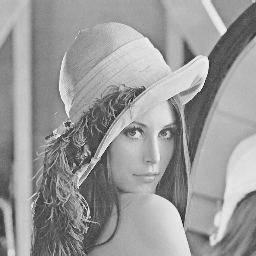

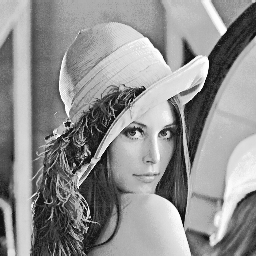

MSE: 35.241238042869064
PSNR: 19.45165492767008
AMBE: 21.156753540039062
SNR: 0.3317308404063262
SSIM: 0.926748744135771


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


In [ ]:
import cv2
import numpy as np

def adaptive_gamma_correction(image, gamma=1.0):
    # Calculate the gamma correction lookup table
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)
    
    # Split the image into color channels
    channels = cv2.split(image)
    
    # Apply gamma correction to each channel
    corrected_channels = []
    for channel in channels:
        corrected_channel = cv2.LUT(channel, table)
        corrected_channels.append(corrected_channel)
    
    # Merge the corrected channels back into an image
    corrected_image = cv2.merge(corrected_channels)
    
    return corrected_image

import cv2 as cv
import numpy as np
import scipy.ndimage

# equivalent to fspecial
def matlab_style_gauss2D(shape=(1,9),sigma=1.0762):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def bpdhe(im):
  im = im.astype('uint8')
  hsv = cv.cvtColor(im, cv.COLOR_RGB2HSV)
  h,s,v = cv.split(hsv)
  h =  (h /255.0)
  s =  (s /255.0)

  ma = np.max(v)
  mi = np.min(v)
  bins = (ma-mi) + 1
  hist_i = np.histogram(v,bins=bins)
  hist_i = hist_i[0].reshape(1,len(hist_i[0]))
  gausFilter = matlab_style_gauss2D()
  #blur_hist = scipy.ndimage.convolve(hist_i[0], gausFilter, mode='nearest')
  blur_hist = cv.filter2D(hist_i.astype('float32'),-1,gausFilter, borderType=cv.BORDER_REPLICATE)
  derivFilter = np.array([[-1,1]])
  deriv_hist =  cv.filter2D(blur_hist.astype('float32'),-1,derivFilter, borderType=cv.BORDER_REPLICATE)
  sign_hist = np.sign(deriv_hist)
  meanFilter = np.array([[1/3,1/3,1/3]])
  smooth_sign_hist =  np.sign(cv.filter2D(sign_hist.astype('float32'),-1,meanFilter, borderType=cv.BORDER_REPLICATE))
  cmpFilter = np.array([[1,1,1,-1,-1,-1,-1,-1]])
  #index = np.zeros(shape=(1,3))
  #index[0] = 0
  p = 1
  index = [0]
  for n in range(0,bins-7):
    C = (smooth_sign_hist[0][n:n+8] == cmpFilter)*1
    if np.sum(C) == 8.0:
      p+=1
      index.append(n+3)

  index.append(bins)

  factor = np.zeros(shape=(len(index)-1,1))
  span = factor.copy()
  M = factor.copy()
  rangee = factor.copy()
  start = factor.copy()
  endd = factor.copy()
  sub_hist = []
  for m in range(0,len(index)-1):
    sub_hist.append( np.array(hist_i[0][index[m]:index[m+1]]) ) 
    M[m] = np.sum(sub_hist[m])
    low = mi + index[m]
    high = mi + index[m+1] - 1
    span[m] = high - low + 1
    factor[m] = span[m] * np.log10(M[m])
    factor_sum = np.sum(factor)
  for m in range(0,len(index)-1):
    rangee[m] = np.round((256-mi)*factor[m]/factor_sum)
  start[0] = mi
  endd[0] = mi + rangee[0]-1
  for m in range(1,len(index)-1):
    start[m] = start[m-1] + rangee[m-1]
    endd[m] = endd[m-1] + rangee[m]

  y = []
  s_r = np.zeros(shape=(1,mi))
  s_r = s_r.tolist()
  s_r = (s_r[0])
  for m in range(0, len(index)-1):
    hist_cum = np.cumsum(sub_hist[m]) 
    c = hist_cum/M[m]
    y.append( np.array(np.round(start[m]+(endd[m]-start[m])*c)) )
    x = y[m].tolist()
    s_r = s_r + x
  i_s = np.zeros(shape=v.shape)
  for n in range(mi,ma+1):
    lc = (v== n)
    i_s[lc] = (s_r[n])/255
  hsi_0 = cv.merge([h, s, i_s])
  hsi_0 = (hsi_0 * 255).astype('uint8')
  d = cv.cvtColor(hsi_0, cv.COLOR_HSV2RGB)

  return d


def main():
    # Load the image
    image = cv2.imread('/content/lena.png', cv2.IMREAD_COLOR)
    
    # Apply adaptive gamma correction
    agcie_image = adaptive_gamma_correction(image, gamma=1.5)
    
    # Apply BPDHE to the AGCIE image
    merged_image = bpdhe(agcie_image)
    
    # Display the original, AGCIE, and merged images
    cv2_imshow(image)
    cv2_imshow(agcie_image)
    cv2_imshow(merged_image)
    q = Quantitation()
    print("MSE:",q.MSE(image,merged_image))
    print("PSNR:",q.PSNR(image,merged_image))
    print("AMBE:",q.AMBE(image,merged_image))
    print("SNR:",q.SNR(image,merged_image))
    print("SSIM:",q.SSIM(image,merged_image))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()

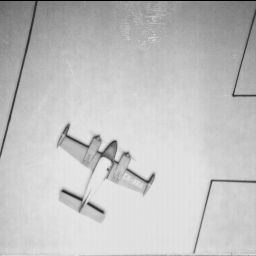

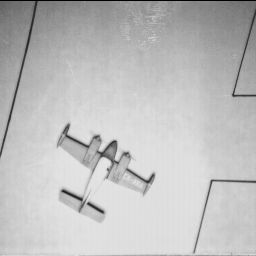

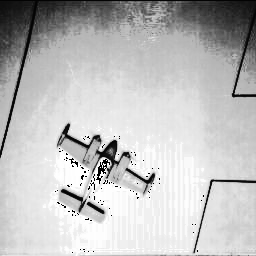

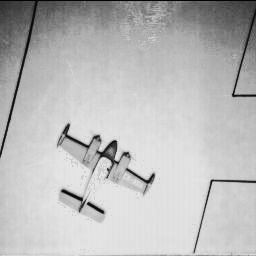

time =  0.18614530563354492
MSE: 35.785894634310694
PSNR: 17.158957455537855
AMBE: 3.28125
SNR: 0.43989407173883327
SSIM: 0.8134822896078996


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


In [ ]:
image = cv2.imread('/content/5.1.11.jpg', cv2.IMREAD_COLOR)
start = time.time()    
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)


foreground = agcie_image
background = merged_image
alpha = image
 
# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
 
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
 
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
 
# Add the masked foreground and background.
outImage = cv2.add(foreground, background)
 
# Display image
cv2_imshow(outImage)
outImage = outImage/255



end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))

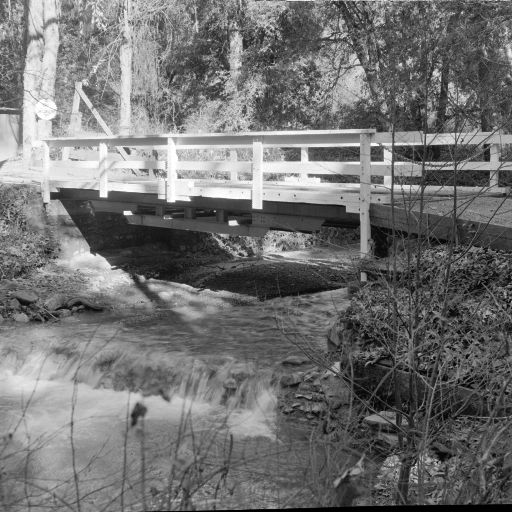

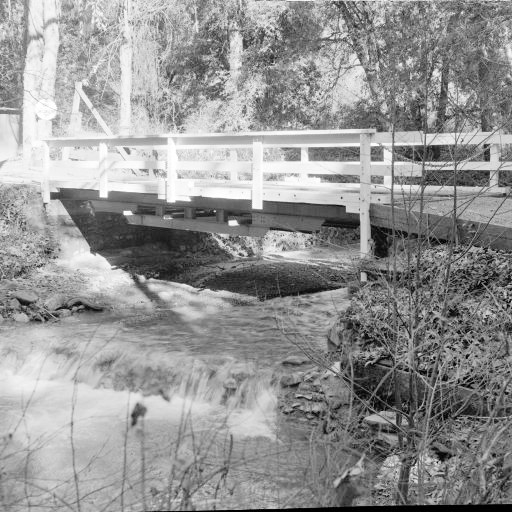

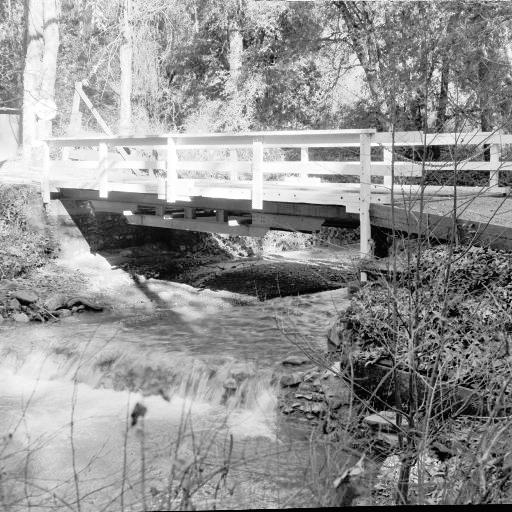

time =  0.7271180152893066
MSE: 35.83017034231911
PSNR: 16.984912998605658
AMBE: 33.01572799682617
SNR: 0.35974316219270086


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


SSIM: 0.9042933874506621


In [ ]:
image = cv2.imread('/content/5.2.10.jpg', cv2.IMREAD_COLOR)
start = time.time() 
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)
end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))

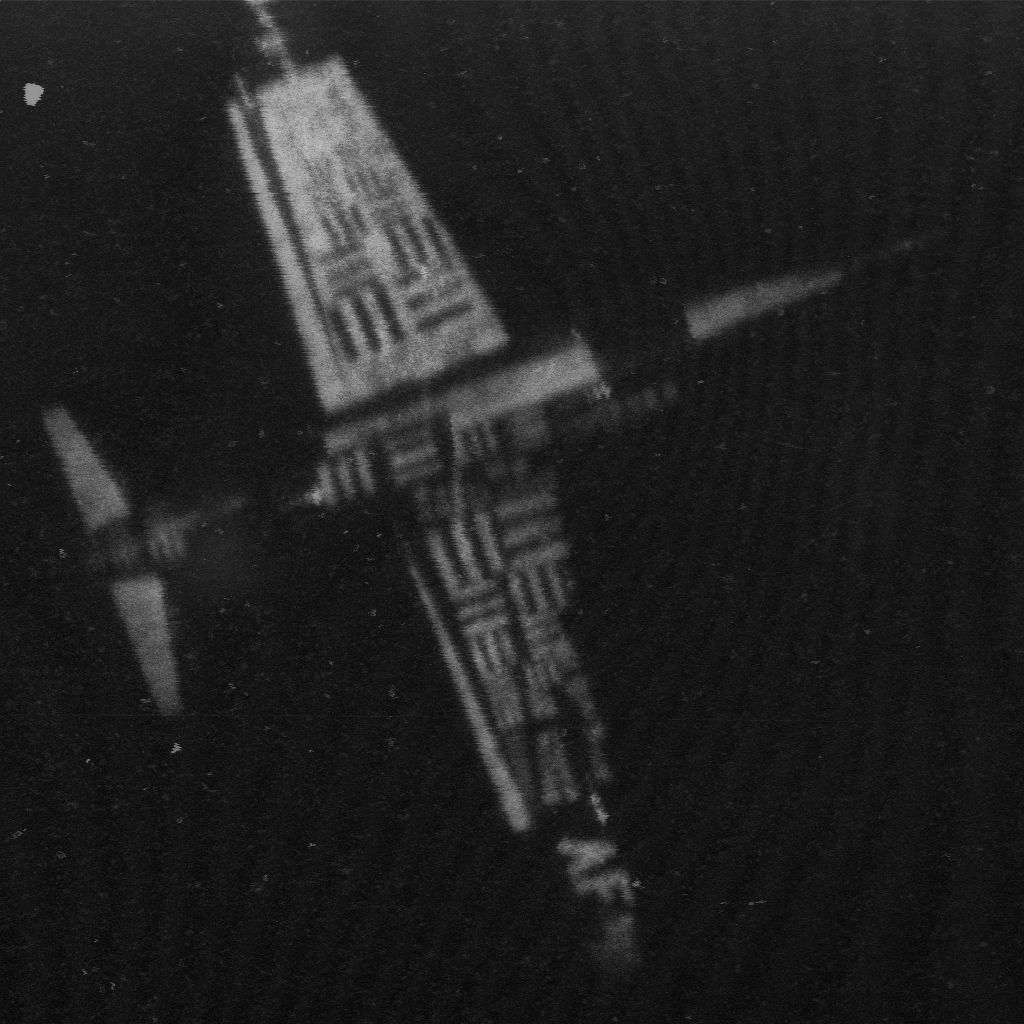

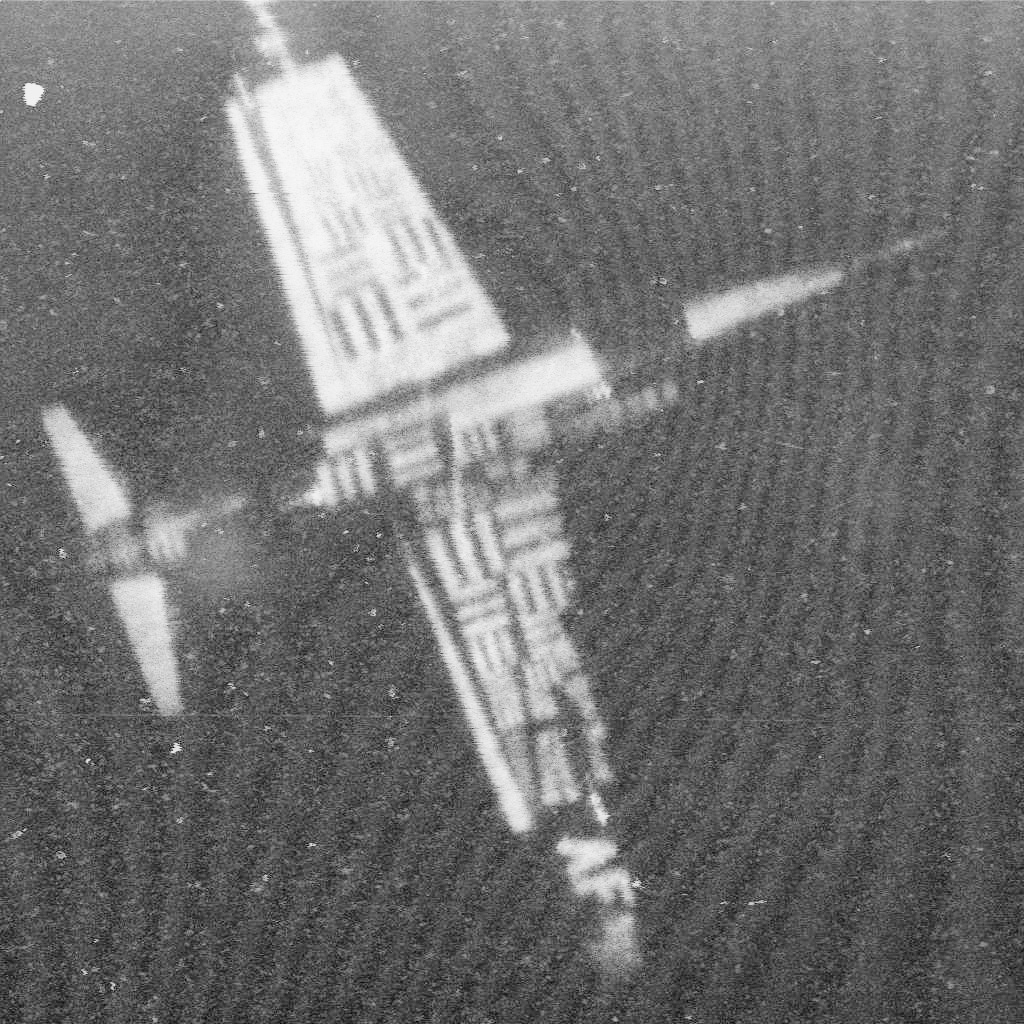

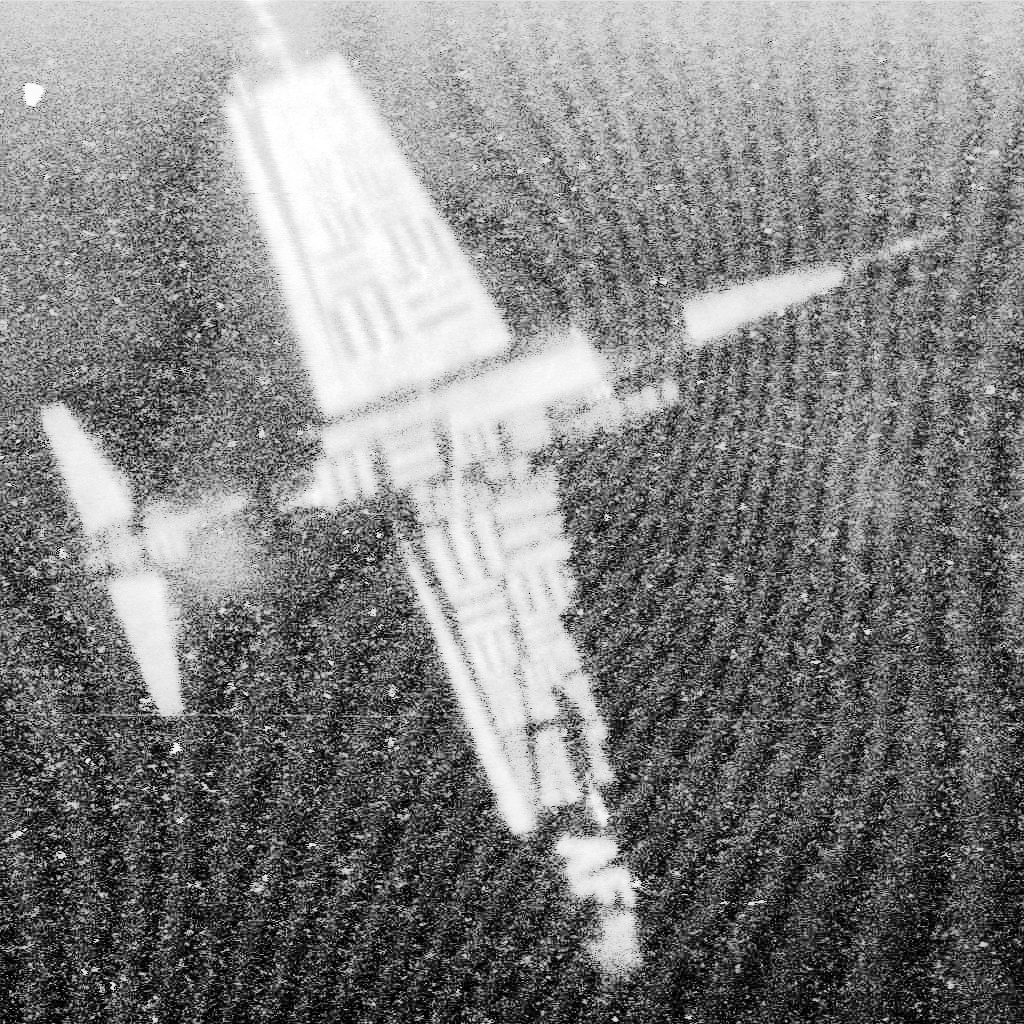

time =  2.732426166534424
MSE: 39.572098083402786
PSNR: 7.1758037464477455
AMBE: 96.65437316894531
SNR: 0.4783313603239585


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


SSIM: 0.16037601789858338


In [ ]:
image = cv2.imread('/content/7.2.01.jpg', cv2.IMREAD_COLOR)
start = time.time() 
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)
end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))

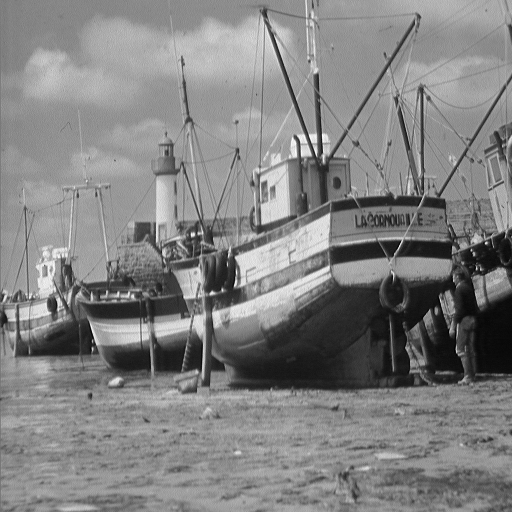

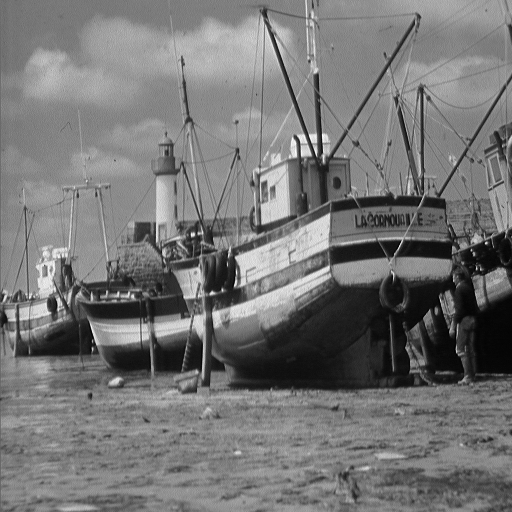

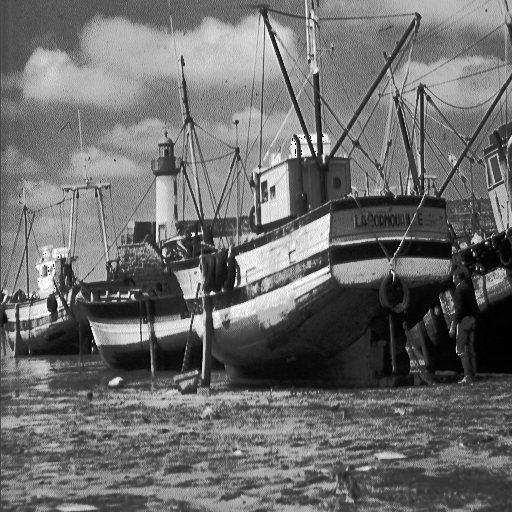

time =  0.6429216861724854
MSE: 35.31839730005351
PSNR: 19.109117499752145
AMBE: 20.42410659790039
SNR: 0.939692361841491
SSIM: 0.7935575153283111


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


In [ ]:
image = cv2.imread('/content/boat.512.tiff', cv2.IMREAD_COLOR)
start = time.time()
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)


end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))

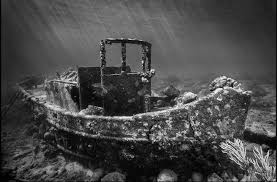

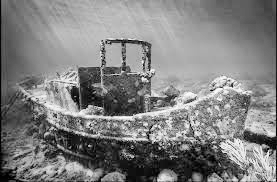

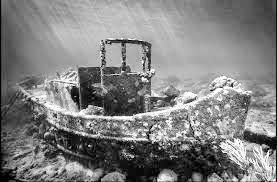

time =  0.15674901008605957
MSE: 37.134715059603415
PSNR: 12.577920775365774
AMBE: 55.72376720752173
SNR: 0.3313854361314951
SSIM: 0.7834976975447203


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


In [ ]:
image = cv2.imread('/content/images (1).jpeg', cv2.IMREAD_COLOR)
start =time.time()
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)
end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))

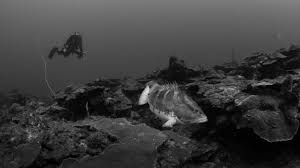

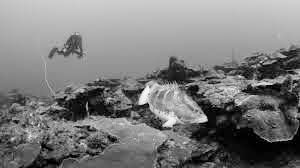

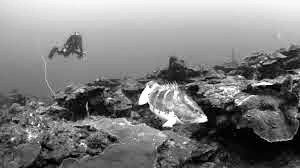

time =  0.16518950462341309
MSE: 37.83958324385563
PSNR: 10.693553251969
AMBE: 66.08952380952381
SNR: 0.3464087213170983
SSIM: 0.6759530428081982


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


In [ ]:
image = cv2.imread('/content/images (2).jpeg', cv2.IMREAD_COLOR)
start = time.time()
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)
end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))

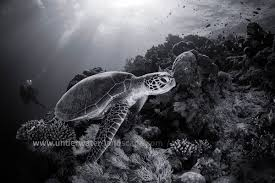

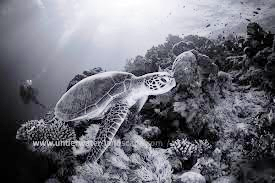

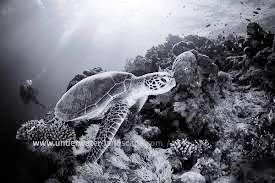

time =  0.16056251525878906
MSE: 36.223615391595054
PSNR: 15.513822625488583
AMBE: 36.88496770988574
SNR: 0.30406356832086956
SSIM: 0.8116025430398203


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


In [ ]:
image = cv2.imread('/content/images (3).jpeg', cv2.IMREAD_COLOR)
start = time.time()  
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)
end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))

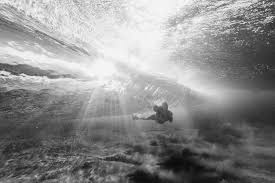

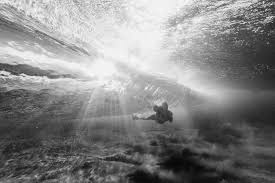

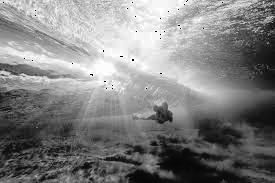

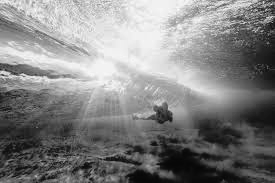

time =  0.17249417304992676
MSE: 34.28814940071249
PSNR: 24.22509120479407
AMBE: 11.645981122702437
SNR: 3.945387611961503
SSIM: 0.9123333856585809


<ipython-input-4-02492e7b48cf>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)


In [ ]:
image = cv2.imread('/content/images.jpeg', cv2.IMREAD_COLOR)
start = time.time()
# Apply adaptive gamma correction
check = IE(image)
agcie_image = check.AGCIE()
# Apply BPDHE to the AGCIE image
merged_image = bpdhe(agcie_image)
    
# Display the original, AGCIE, and merged images
cv2_imshow(image)
cv2_imshow(agcie_image)
cv2_imshow(merged_image)
# # Mhe
# input_image = merged_image
# equalized_image = apply_mhe(input_image)
# # Display the equalized image
# cv2_imshow(equalized_image)


foreground = agcie_image
background = merged_image
alpha = image
 
# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
 
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
 
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
 
# Add the masked foreground and background.
outImage = cv2.add(foreground, background)
 
# Display image
cv2_imshow(outImage)
outImage = outImage/255
end = time.time()
print("time = ",(end - start))
q = Quantitation()
print("MSE:",q.MSE(image,merged_image))
print("PSNR:",q.PSNR(image,merged_image))
print("AMBE:",q.AMBE(image,merged_image))
print("SNR:",q.SNR(image,merged_image))
print("SSIM:",q.SSIM(image,merged_image))